In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e24/sample_submission.csv
/kaggle/input/playground-series-s3e24/train.csv
/kaggle/input/playground-series-s3e24/test.csv


### Importing Data

In [8]:
path = "/kaggle/input/playground-series-s3e24/"

train_data = pd.read_csv(path + "train.csv", index_col = ["id"])
test_data = pd.read_csv(path + "test.csv", index_col = ["id"])

train_data.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

## Exploratory Data Analysis

In [9]:
# How are the clases split in the train data?

for label in train_data["smoking"].value_counts().index:
    print("class {} is {}% of the data". format(label, (train_data["smoking"].value_counts()[label] / train_data.shape[0])*100))

class 0 is 56.26350027628473% of the data
class 1 is 43.736499723715276% of the data


The labels seem to be pretty much evenly distributed, which is good.

In [10]:
# How many missing values are there?

train_data.isnull().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

There are no missing data, which makes sense because this dataset it synthetically made.

In [11]:
train_data.duplicated().sum()

0

In [12]:
# Are there outliers?

train_data.iloc[:,:11].describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,76.874071,98.352552
std,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,8.994642,15.329740
min,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,44.000000,46.000000
25%,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,70.000000,90.000000
50%,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,78.000000,96.000000
75%,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,103.000000
max,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,133.000000,375.000000


Suspected columns are columns that need domain knowledge to determine if their values are legitimate or outliers
or columns whole values seem like they vary a lot 

Since determining and understanding what the possible maximun and minimum values for each of those features is there are 2 ways to proceed:
1. checking out the distribution of values of each variable and seeing where the curves stops and where the unusually high/low values begin. 
2. determining percentiles above or below which samoles will be regarded as outliers

The first way is more manual and time consuming, but might result in more accurate data, while the second one may be worse in quality but easier and faster.

Since htere are not many suspected columns (9), I'll go with the second way.

I chose to replace the ouliers witht the highest/lowest value observed which is not an outlier, but ther options exist like havinf it treplaced with the mean value.

In [13]:
suspected_cols = ["fasting blood sugar", "Cholesterol", "triglyceride", "LDL", "Urine protein", "serum creatinine", "AST", "ALT", "Gtp"]
other_cols = ["height(cm)", "weight(kg)", "waist(cm)", "eyesight(left)", "eyesight(right)", "hearing(left)", "hearing(right)", "systolic", "relaxation"]

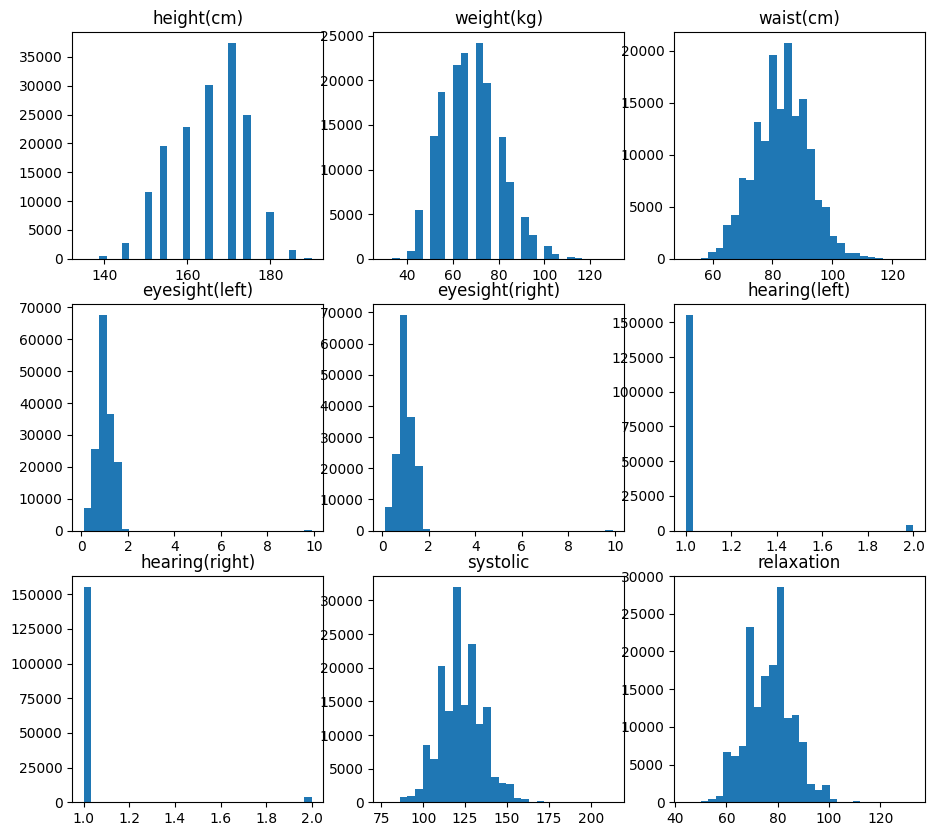

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, figsize = (11, 10))
k = 0
for i in range(3):
    for j in range(3):
        ax[i][j].hist(train_data[other_cols[k]], bins = 30)
        ax[i][j].set_title(other_cols[k])
        k+=1
        
plt.show()

In [15]:
# Dictionary with the name of column and a list where the first element is the low value and
# the second is the high value.


suspected_bounds = {"fasting blood sugar": [50,180], "Cholesterol": [0,320], "triglyceride": [0,420],
          "LDL": [0,270], "Urine protein": [1,6], "serum creatinine": [0,3], 
          "AST": [0,70], "ALT": [0,100], "Gtp": [0,175]}

other_bounds = {"height(cm)": [0,200], "weight(kg)": [40,200], "waist(cm)": [50,130],
          "eyesight(left)": [0,2], "eyesight(right)": [0,2], "hearing(left)": [1,2], 
          "hearing(right)": [1,2], "systolic": [75,175], "relaxation": [40,110]}

In [16]:
for key, value in suspected_bounds.items():
    lower = value[0]
    upper = value[1]
    train_data[key] = train_data[key].transform(lambda x: upper if x > upper else x)
    train_data[key] = train_data[key].transform(lambda x: lower if x < lower else x)
    
for key, value in other_bounds.items():
    lower = value[0]
    upper = value[1]
    train_data[key] = train_data[key].transform(lambda x: upper if x > upper else x)
    train_data[key] = train_data[key].transform(lambda x: lower if x < lower else x)

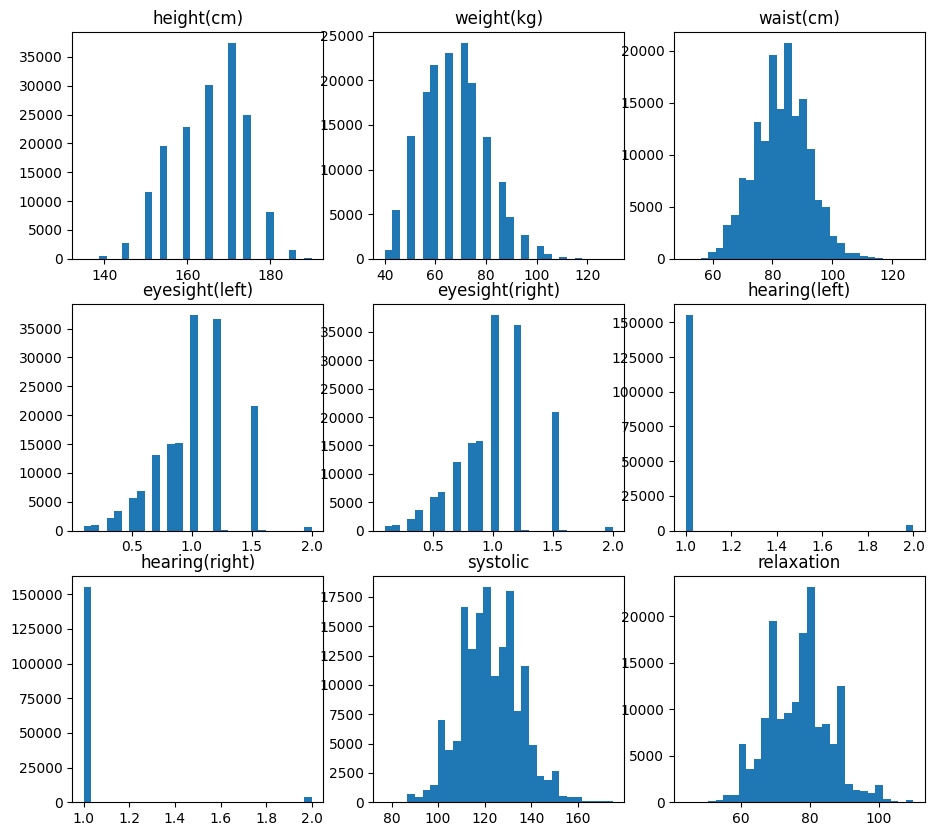

In [17]:
fig, ax = plt.subplots(3, 3, figsize = (11, 10))
k = 0
for i in range(3):
    for j in range(3):
        ax[i][j].hist(train_data[other_cols[k]], bins = 30)
        ax[i][j].set_title(other_cols[k])
        k+=1
        
plt.show()

In [18]:
X = train_data.copy()
y = X.pop("smoking")

In [19]:
train_data.dtypes

age                      int64
height(cm)               int64
weight(kg)               int64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)            int64
hearing(right)           int64
systolic                 int64
relaxation               int64
fasting blood sugar      int64
Cholesterol              int64
triglyceride             int64
HDL                      int64
LDL                      int64
hemoglobin             float64
Urine protein            int64
serum creatinine       float64
AST                      int64
ALT                      int64
Gtp                      int64
dental caries            int64
smoking                  int64
dtype: object

## Scaling



Since the only  model I use is tree-based, there is no need for scaling. Other model might require scaled data.

In [20]:
# Selecting the continous features only - all of the features except "dental caries", "hearing(left)", "hearing(left)", "Urine protein"
# dental caries is binary so it's not categorical  in a sense that One-Hot encoding will be useful because it's already encoded like this

categorical = ["hearing(left)", "hearing(left)", "Urine protein"] 
continous = X.columns.tolist()

for col in ["dental caries"] + categorical:
    try:
        continous.remove(col)
    except ValueError:
        pass

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

Scaler = ColumnTransformer([
    ("Standard scaler", StandardScaler(), continous)
])

### There is no need to encode the categorical features since they are already ordinally encoded

## Creating a Pipleine

It only consists of histogram gradient boosting, but if any preprocessing steps were needed they would be added here.

In [22]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

pipeline = Pipeline ([
    ("boosting classifier", HistGradientBoostingClassifier(categorical_features = [6, 7, 16, 21])) # Letting the model know that feature 21 "dental caries" is categorical
                    ])

## Checking the validation score as a baseline score with cross validation

In [23]:
from sklearn.model_selection import cross_validate

#There is no need for a different CV strategy (than the default Kfold) because it 
#seems that the data is already shuffled, there are no goups and the labels are speard almost equally
CV = cross_validate(pipeline, X, y, scoring='roc_auc', cv = 5)

print("The mean score of the pipeline is: {}".format(CV["test_score"].mean()))

The mean score of the pipeline is: 0.8645942353004663


## Tuning the hyperparameters of the pipeline with nested cross validation and seeing which one is best

In [32]:
from sklearn.model_selection import GridSearchCV, KFold

param_grid = { # 'boosting classifier__learning_rate': [0.1], This is thr default value.
              'boosting classifier__max_leaf_nodes': [62, 82, 31]
              } 

inner_cv = KFold (n_splits=5, shuffle=True)
outer_cv = KFold (n_splits=3, shuffle=True)

tuned_pipeline = GridSearchCV (pipeline, param_grid, scoring='roc_auc', cv=inner_cv)

In [33]:
nested_CV = cross_validate(tuned_pipeline, X, y, scoring='roc_auc', cv=outer_cv, return_estimator = True)

print("The mean score of the pipeline is: {}".format(nested_CV["test_score"].mean()))

The mean score of the pipeline is: 0.864214461972403


In [35]:
for i in range (3):
    print(f"The best params for estimator {i} are {nested_CV['estimator'][i].best_params_} and its score is {nested_CV['test_score'][i]}")

The best params for estimator 0 are {'boosting classifier__max_leaf_nodes': 62} and its score is 0.8627536823109485
The best params for estimator 1 are {'boosting classifier__max_leaf_nodes': 82} and its score is 0.8661237097649443
The best params for estimator 2 are {'boosting classifier__max_leaf_nodes': 31} and its score is 0.8637659938413162


### Possibly more hyperparameters could have been searched, but in this search the default values scored the best in each CV fold

In [27]:
# The best estimator would be the one with the hyperparameters that scored the best
# Here it does not make a difference because the best parameters were the defaults

best_pipeline = nested_CV["estimator"][1]
#best_estimator_
best_pipeline.fit(X,y)
results = best_pipeline.predict_proba(test_data)

In [28]:
# Out of the 2D array take all the rows of the second column
results[:,1]
results = pd.Series(results[:,1])

Predict probability returns an array with the numner of columns matching the number of groups predicted the probability to receive it

In [29]:
submission = pd.DataFrame({"id":test_data.index, "smoking":results})
submission.head()

,id,smoking
0,159256,0.583731
1,159257,0.281080
2,159258,0.366078
3,159259,0.014234
4,159260,0.571863


In [31]:
submission.to_csv('submission_with_categoricals.csv',index = False)